In [6]:
from datetime import datetime
from tqdm import tqdm
import numpy as np
import pandas as pd
import joblib

from wandb_utils import get_wandb_history
from miner_performance_tracker import MinerPerformanceTracker
from reward import get_rewards, old_get_rewards
from scoring import update_scores   
from plotting import plot_metric, plot_multi_validator_metric
from utils import average_challenges_per_tempo


## Query W&B or Load Locally Cached Data

In [7]:
load_from_file = True
fname = 'vali_histories.pkl'

start_ts = 1727846400
validators = ['validator-193-1.1.0', 'validator-19-1.1.0', 'validator-107-1.1.0']
history_dfs = {}

if load_from_file:
    history_dfs = joblib.load(fname)
else:
    for vali in validators:
        print(f"Loading data from {vali}")
        history_dfs[vali] = get_wandb_history(
            project='bitmind-subnet',
            entity='bitmindai',
            validator_name=vali,
            start_ts=start_ts,
            end_ts=None, 
            verbosity=0)

    joblib.dump(history_dfs, fname)

for vali, history_df in history_dfs.items():
    print(vali)
    avg, counts = average_challenges_per_tempo(history_df)
    format_time = lambda v: datetime.fromtimestamp(v).strftime('%Y-%m-%dT%H:%M:%S')
    print(f'\tDate Range: {format_time(history_df._timestamp.min())} : {format_time(history_df._timestamp.max())}')
    print(f'\tDataFrame shape: {history_df.shape}')
    print(f'\tAverage Challenges Per Tempo: {avg}')
    print(f'\t\tChallenges Per Tempo: {counts}')
    

validator-193-1.1.0
	Date Range: 2024-10-02T02:37:00 : 2024-10-02T21:03:35
	DataFrame shape: (897, 4)
	Average Challenges Per Tempo: 56.0625
		Challenges Per Tempo: [60, 60, 59, 59, 60, 58, 60, 59, 58, 59, 57, 53, 56, 58, 58, 23]
validator-19-1.1.0
	Date Range: 2024-10-02T04:29:51 : 2024-10-02T20:59:16
	DataFrame shape: (739, 4)
	Average Challenges Per Tempo: 52.785714285714285
		Challenges Per Tempo: [53, 56, 56, 51, 55, 50, 57, 54, 55, 54, 50, 52, 55, 41]
validator-107-1.1.0
	Date Range: 2024-10-02T02:33:06 : 2024-10-02T21:05:43
	DataFrame shape: (816, 4)
	Average Challenges Per Tempo: 51.0
		Challenges Per Tempo: [57, 52, 54, 52, 52, 56, 54, 54, 50, 50, 54, 48, 49, 56, 53, 25]


## Run Simulation

In [8]:
def run_simulation(history_df: pd.DataFrame, limit: int):
    """
    Iteratively computes rewards and scores from labels and miner predictions

    Args:
        history_df: DataFrame where each row is a challenge, and contains columns 
            'label', 'pred', and 'miner_uid'
        limit: Number of rows to iterate over (for debugging or running over smaller windows)

    Returns:
        history_df with additional columns 'rewards_new', 'rewards_old', 'scores_new', 'scores_old'
        Note: if limit is < len(history_df), the first `limit` rows will contain rewards and scores, and 
        the rest will be nan.
    """
    perf_tracker = MinerPerformanceTracker()
    
    miner_sample_size = history_df['miner_uid'].apply(len).unique()[0]
    
    keys = ['old', 'new']
    scores = {k: np.zeros(256, dtype=np.float32) for k in keys}
    
    score_history = {k: [] for k in keys}
    reward_history = {k: [] for k in keys}
    
    limit = len(history_df) if limit is None else limit
    
    progress_bar = tqdm(
        history_df.iterrows(), 
        total=limit,
        desc="Computing Rewards and Scores")
    
    for i, challenge_row in progress_bar:
        if i >= limit:
            break
        
        label = challenge_row['label']
        preds = challenge_row['pred']
        uids = challenge_row['miner_uid']
        
        new_rewards = get_rewards(
            label,
            preds,
            uids,
            [1] * miner_sample_size, # mocking hotkeys for now
            perf_tracker)
    
        old_rewards = old_get_rewards(label, preds)
    
        scores['new'] = update_scores(scores['new'], new_rewards, uids)
        scores['old'] = update_scores(scores['old'], old_rewards, uids)
    
        reward_history['new'].append(new_rewards)
        reward_history['old'].append(old_rewards)
    
        score_history['new'].append(scores['new'])
        score_history['old'].append(scores['old'])
    
    for k in reward_history:
        diff = len(history_df) - len(reward_history[k])
        if diff != 0:
            reward_history[k] += [np.nan] * diff
        history_df['rewards_' + k] = reward_history[k]

    for k in score_history:
        diff = len(history_df) - len(score_history[k])
        if diff != 0:
            score_history[k] += [np.nan] * diff
        history_df['scores_' + k] = score_history[k]
    return history_df

In [ ]:
score_num_challenges = 50
scored_dfs = {}
for vali, history_df in history_dfs.items():
    print(f"Computing Rewards and Scores for {vali}")
    scored_df = run_simulation(history_df, limit=score_num_challenges)
    scored_dfs[vali] = scored_df[scored_df.scores_old.notna()]

Computing Rewards and Scores for validator-193-1.1.0


Computing Rewards and Scores:  62%|██████▏   | 31/50 [00:24<00:15,  1.20it/s]

## I. reward100 * .5 + reward10 * .25 + correct * .25

### Inspect Same Miner over Multiple Validators

#### Scores

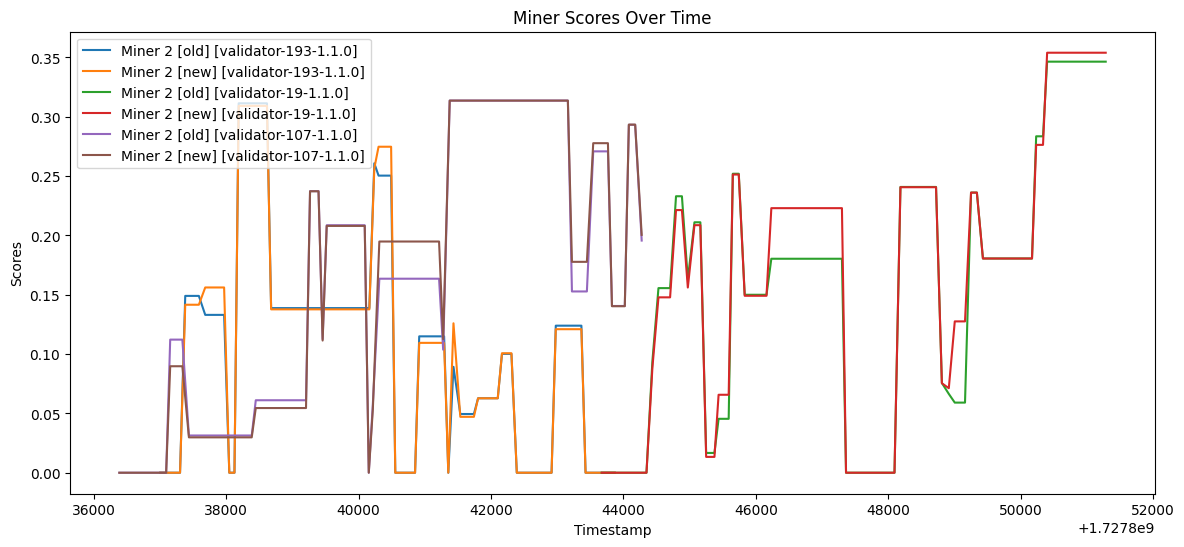

In [59]:
uids = [2]
plot_multi_validator_metric(scored_dfs, 'scores', ['old', 'new'], uids=uids, map_uids_to_colors=False)

#### Rewards

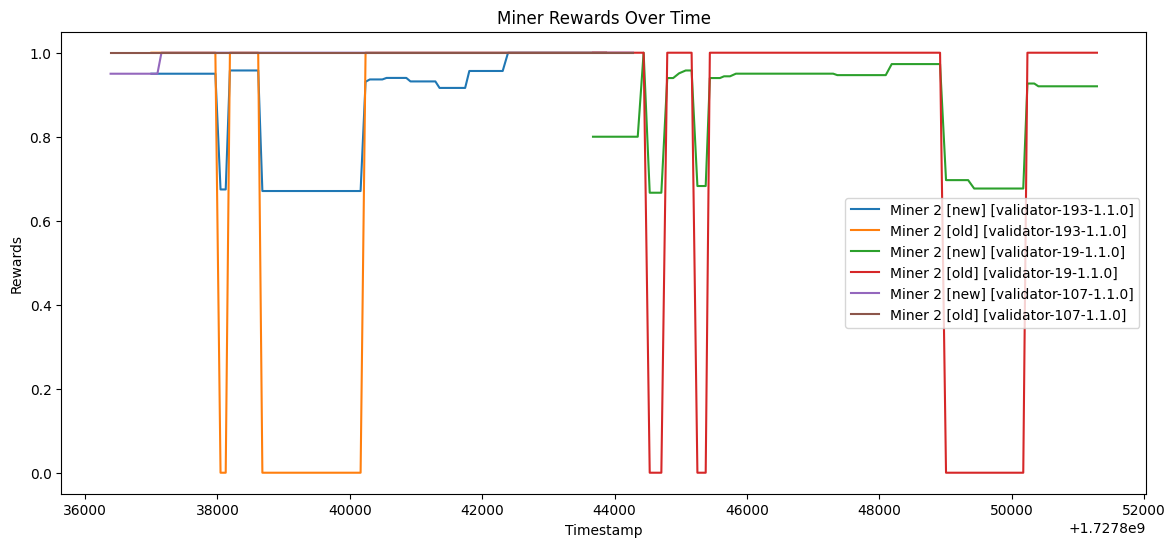

In [58]:
plot_multi_validator_metric(scored_dfs, 'rewards', ['new', 'old'], uids=uids, map_uids_to_colors=False)

### Inspect Multiple Miners on Individual Validators

In [6]:
for vali, scored_df in scored_dfs.items():
    print(vali)
    plot_metric(scored_df, 'scores', uids=uids, suffixes=['new', 'old'], map_uids_to_colors=map_uids_to_colors)


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 for vali, scored_df in scored_dfs.items():                                                   │
│   2 │   print(vali)                                                                              │
│   3 │   plot_metric(scored_df, 'scores', uids=uids, suffixes=['new', 'old'], map_uids_to_col     │
│   4                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'scored_dfs' is not defined

## reward100 * .5 + reward10 * .25 + correct * .25

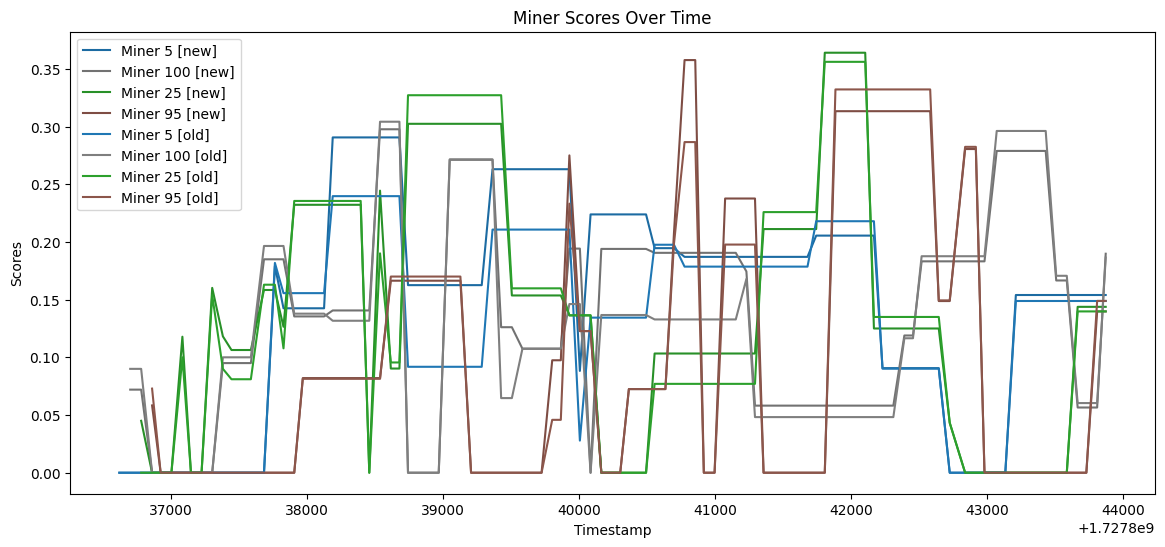

In [11]:
plot_metric(scored_df, 'scores', uids=uids, suffixes=['new', 'old'], map_uids_to_colors=map_uids_to_colors)


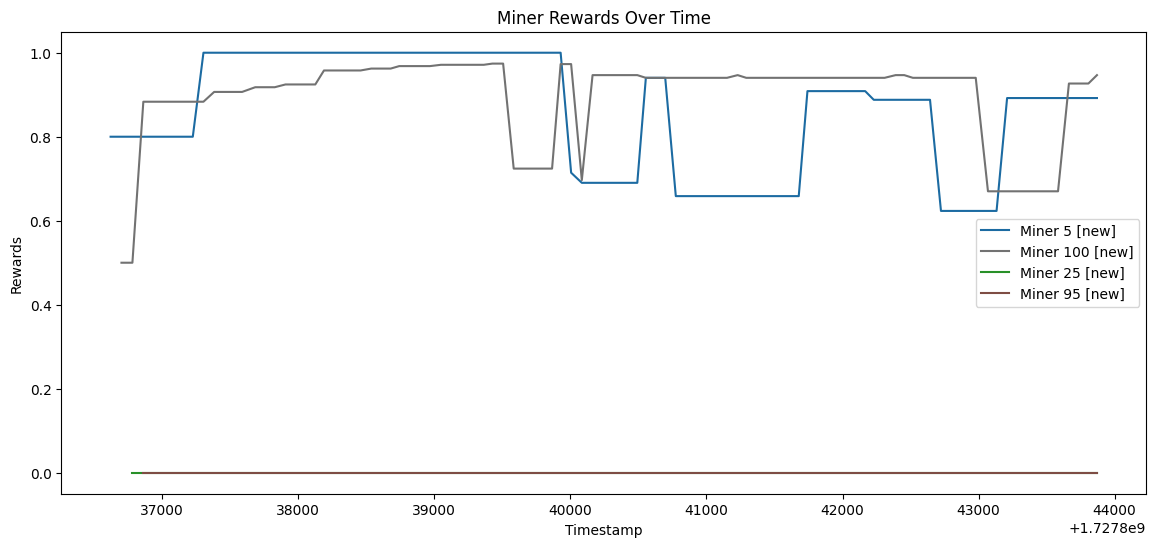

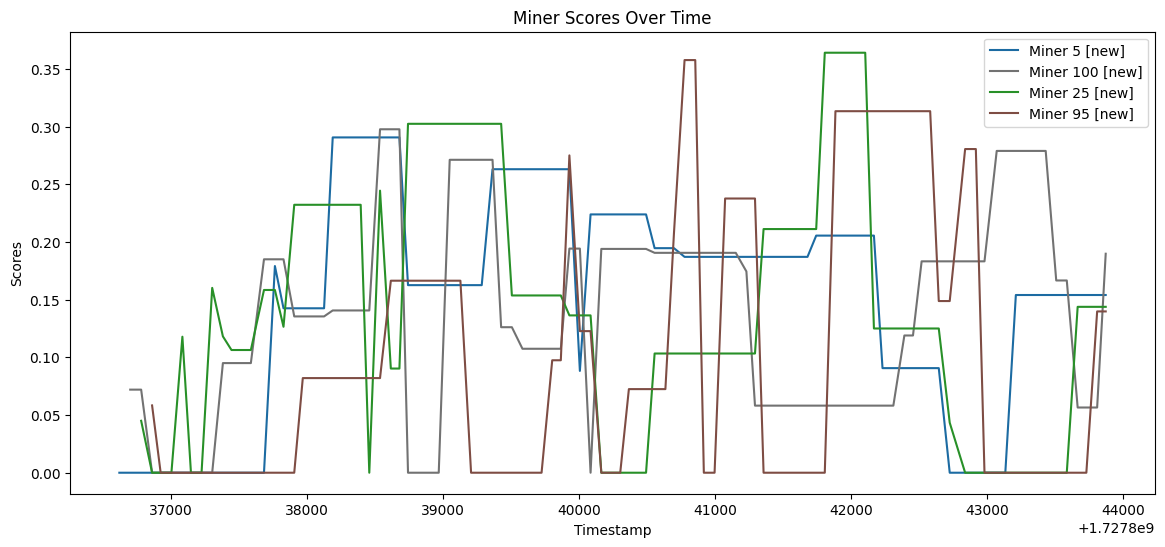

In [9]:
uids = [5,25,95,100]
map_uids_to_colors = True

plot_metric(scored_df, 'rewards', uids=uids, suffixes=['new'], map_uids_to_colors=map_uids_to_colors)
plot_metric(scored_df, 'scores', uids=uids, suffixes=['new'], map_uids_to_colors=map_uids_to_colors)


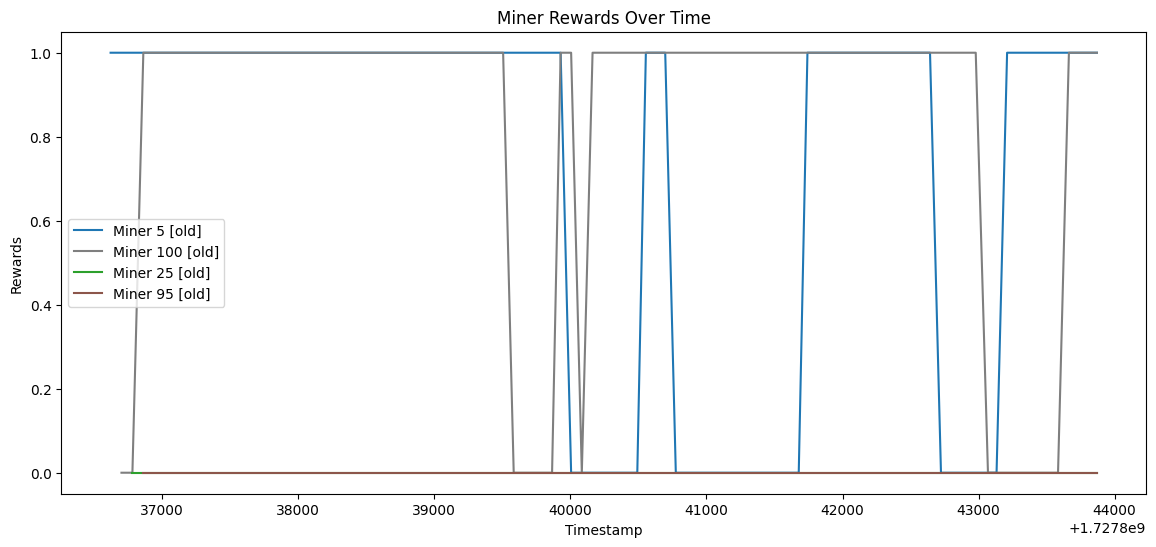

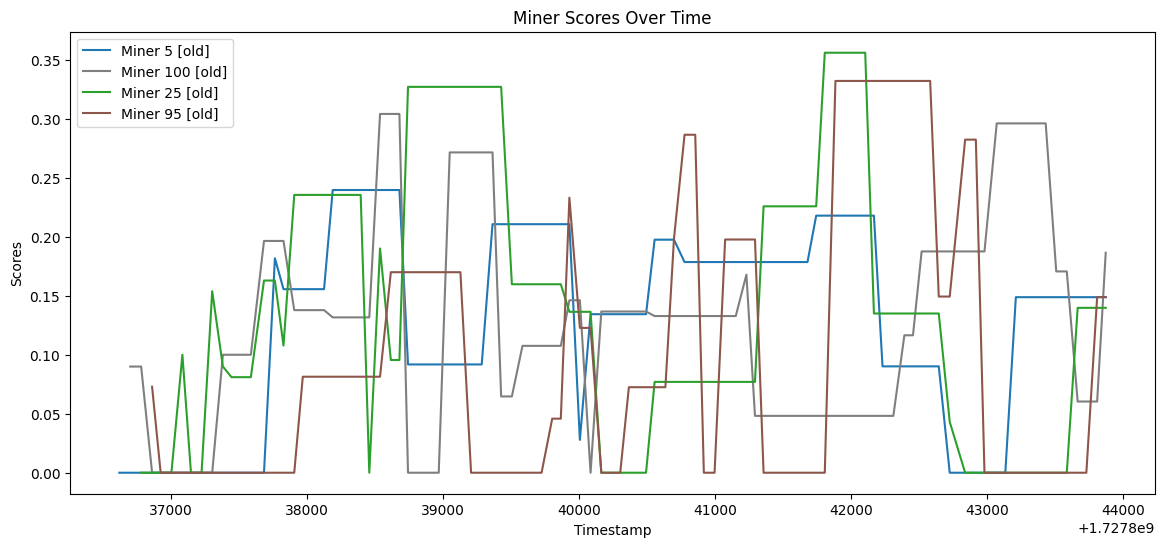

In [10]:
uids = [5,25,95,100]
map_uids_to_colors = True

plot_metric(scored_df, 'rewards', uids=uids, suffixes=['old'], map_uids_to_colors=map_uids_to_colors)
plot_metric(scored_df, 'scores', uids=uids, suffixes=['old'], map_uids_to_colors=map_uids_to_colors)


## reward10 * .2 + correct * .8

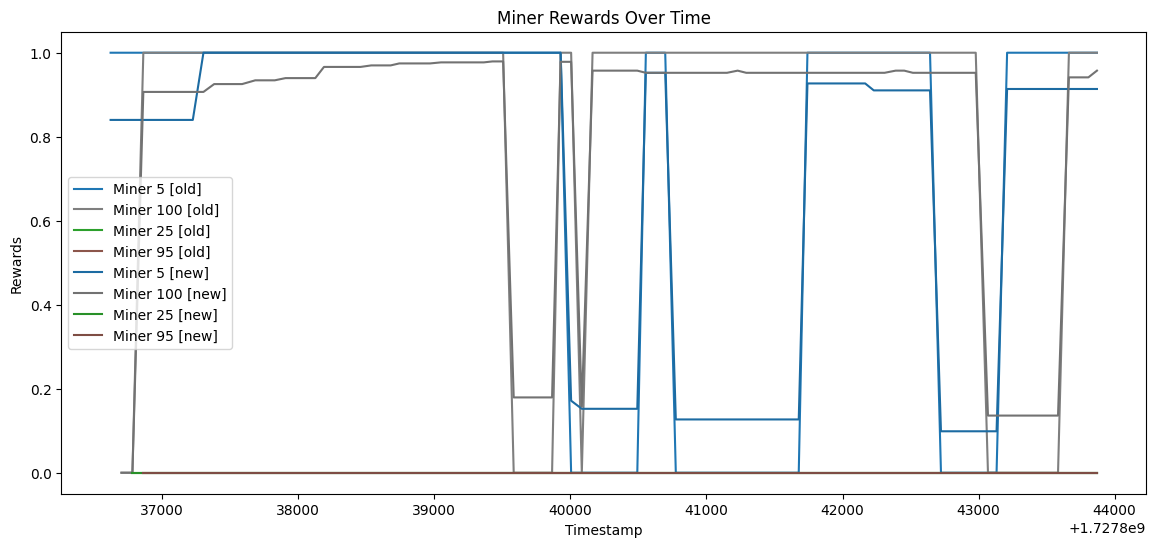

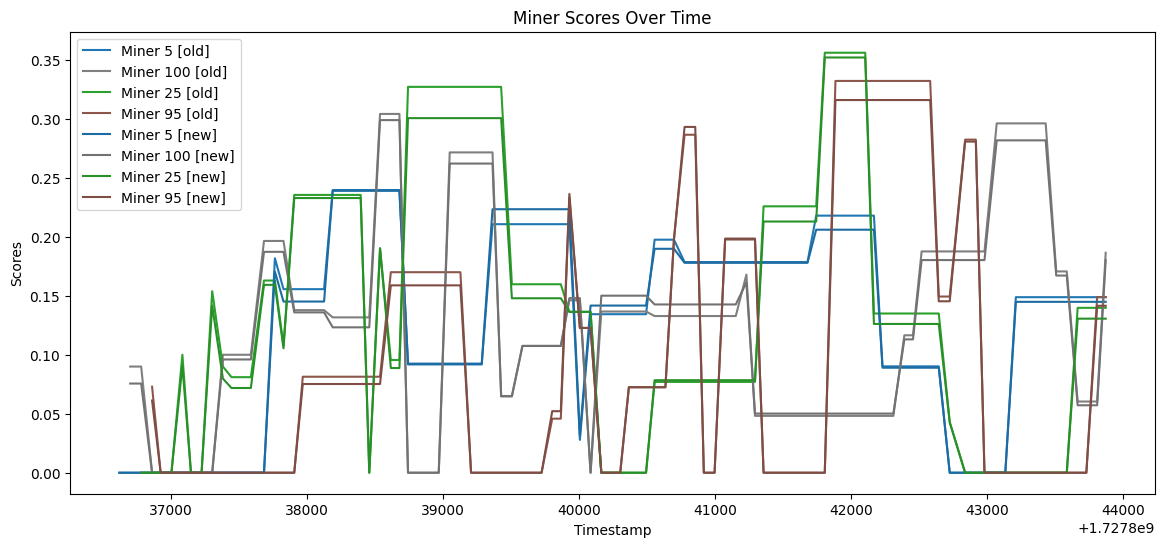

In [43]:
uids = [5,25,95,100]
map_uids_to_colors = True

plot_metric(scored_df, 'rewards', uids=uids, map_uids_to_colors=map_uids_to_colors)
plot_metric(scored_df, 'scores', uids=uids, map_uids_to_colors=map_uids_to_colors)
